# AVISO Inversion with all data and swath data, no error

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from tqdm import tqdm
from aviso_rossby_wave import skill_matrix
from aviso_rossby_wave import reverse_vector, make_ssh_predictions
from aviso_rossby_wave import build_swath, inversion

## Starting Date

In [2]:
day0, day1 = 0, 1 # April 1st, 2017 # day0, day1 =  1856, 1857 July 1st, 2017
start_date = '2016-06-01' ## starting date
n_waves = '450' #number of waves

### Stratification paramters

In [3]:
Phi0 = 45 # central latitude (φ0)
Omega = 7.27e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 # meters
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N
g = 9.81 # gravity 

## Subset 10 degree by 10 degree of ocean

In [4]:
lonidx_west, lonidx_east  =  60, 100
latidx_south, latidx_north = 34, 74

In [5]:
avisso_ds = xr.open_dataset('./aviso_msla_ccs_5d.nc')
SSHA = avisso_ds.msla[latidx_south:latidx_north,lonidx_west:lonidx_east,  :]

In [6]:
T_time = avisso_ds.time.data[day0:] * 864000
date_time = avisso_ds.date_time.data[day0:]
date_time[0], avisso_ds.msla.shape, SSHA.shape # longtitude, latitude, time

(numpy.datetime64('2016-06-01T00:00:00.000000000'),
 (104, 184, 150),
 (40, 40, 150))

In [7]:
ssha_time_mean = SSHA.mean(axis = -1)

In [8]:
SSHA = SSHA - SSHA.mean(axis = -1) - SSHA.mean(axis = 0)

In [9]:
SSHA_masked = np.ma.masked_invalid(SSHA)

In [10]:
ssha_mask = np.ma.getmask(SSHA_masked)

In [11]:
lon, lat = (360 - avisso_ds.lon[lonidx_west:lonidx_east].data) * -1, avisso_ds.lat[latidx_south:latidx_north].data

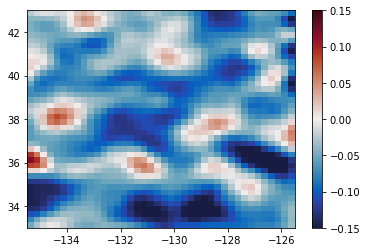

In [12]:
plt.pcolormesh(lon, lat, SSHA[:, :, 0], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
plt.colorbar()

### Inversion with selecetd swath data points

In [13]:
strat_ds = xr.open_dataset('./stratification_sample_ccs.nc')

In [14]:
Psi = strat_ds.Psi.data
#Rm = 5.5e4 
#wavespeed = np.array([Rm * f0])
MModes = 1
wavespeed = strat_ds.C2[:MModes].data  #np.array([Rm * f0])

#### Rossby deformation radius

In [15]:
Rm = wavespeed/f0
Rm/1e3 # km

array([65.66813367])


### the aviso data is sampled at 5-day intervals

In [16]:
selected_lat = 0
selected_time = 8 # 5 * 8 = 40 days

#### Rossby wave estimate

In [17]:
wave_ds = xr.open_dataset('./rossby_wave_estimate_' + start_date +'_' + n_waves + 'waves.nc')

In [18]:
k_n_orig, l_n_orig = wave_ds.k_n.data, wave_ds.l_n.data
amp = wave_ds.Amplitudes.data
time= wave_ds.time.data
MSLA_fwd = wave_ds.MSLA_forward.data

In [19]:
k_n = k_n_orig.reshape(len(k_n_orig), MModes)
l_n = l_n_orig.reshape(len(l_n_orig), MModes)

In [20]:
MSLA0 = SSHA_masked[:, :, day0:day1]
#MSLA0 = MSLA_fwd[:, :, 0:1]

In [21]:
skill, SSHA_vector, dlon, dlat, Iindex, Jindex, Tindex, Rm = skill_matrix(MSLA0, Psi, k_n, l_n, MModes, wavespeed, lon, lat, T_time)
M = skill.size

100%|████████████████████████████████████████| 450/450 [00:03<00:00, 120.86it/s]


In [22]:
kk, ll = np.meshgrid(k_n, l_n)

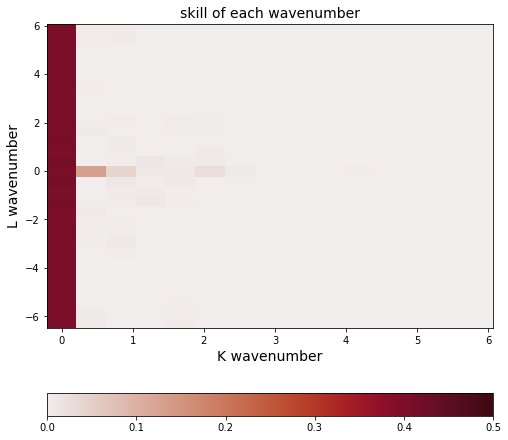

In [23]:
plt.figure(figsize = (8, 8))
plt.pcolor(kk, ll, skill[:, :, 0].T, cmap = cmo.cm.amp, vmin = 0, vmax = 0.5)
plt.xlabel('K wavenumber', fontsize = 14)
plt.ylabel('L wavenumber', fontsize = 14)
plt.colorbar(orientation = 'horizontal')
plt.title('skill of each wavenumber', fontsize = 14)
plt.savefig('./skill_matrix_KLwaves_' + str(M) + '.png')

#### Build basis function H matrix

In [24]:
MModes = 1
H_cos, H_sin = np.zeros([len(SSHA_vector), M]), np.zeros([len(SSHA_vector), M])
H_all = np.zeros([len(SSHA_vector), M*2])
freq_n = np.zeros([M, MModes])

count = 0 
for kk in range(len(k_n)):
    for ll in range(len(l_n)):
        for mm in range(MModes):
            freq_n[count, mm] =  -1 * (Beta * k_n[kk]) / (k_n[kk] ** 2 + l_n[ll] ** 2 + Rm ** (-2))
            count += 1

In [25]:
nn = 0 
for kk in range(len(k_n)):
    for ll in range(len(l_n)):
        for mm in range(MModes):
            for count in range(len(Iindex)):
                H_cos[count, nn] = Psi[0, mm] * np.cos(k_n[kk] * dlon[int(Iindex[count])] + l_n[ll] * dlat[int(Jindex[count])] - freq_n[nn] * T_time[int(Tindex[count])])  
                H_sin[count, nn] = Psi[0, mm] * np.sin(k_n[kk] * dlon[int(Iindex[count])] + l_n[ll] * dlat[int(Jindex[count])] - freq_n[nn] * T_time[int(Tindex[count])])
            nn += 1

In [26]:
H_all[:, 0::2] = H_cos 
H_all[:, 1::2] = H_sin

#### signal to noise ratio

Signal to noise ratio decreases in proportion to $k^{-2}$

In [27]:
EXP = -1

In [28]:
P_over_R = np.eye(2 * M, 2 * M)
counter = 0
for kk in k_n:
    for ll in l_n:
        counter += 1
        kl = np.sqrt(kk ** 2 + ll ** 2)
        P_over_R[counter, counter] = 0.1 * kl ** EXP
        
#for ii in range(2 * M): 
#    if(ii!=0):
#        P_over_R[ii, ii] = 0.01 * ii ** -1

In [29]:
P_over_R.shape

(900, 900)

#### solve for amplitudes with all data

In [30]:
amp_all_data, ssh_estimated = inversion(SSHA_vector, H_all, P_over_R) 

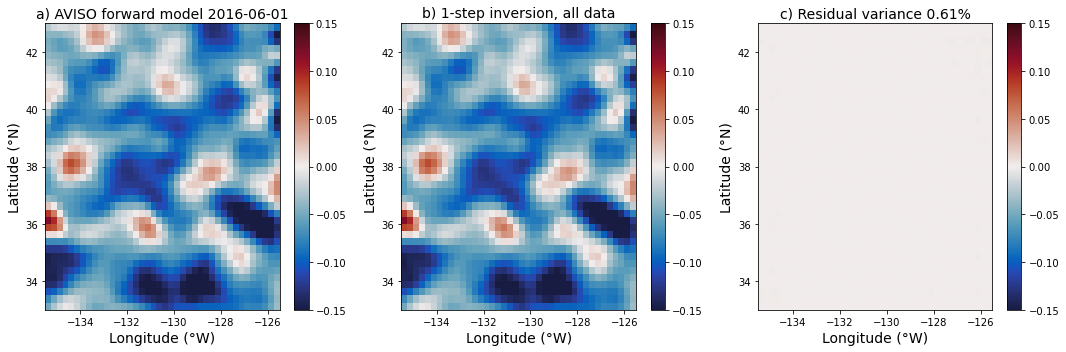

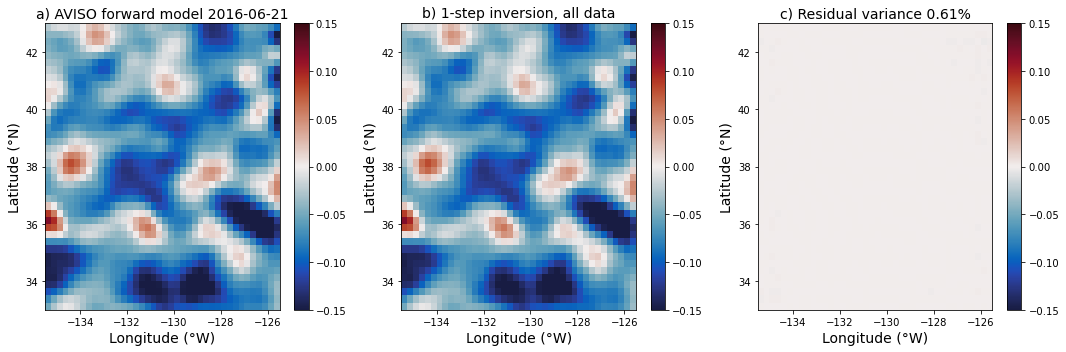

In [31]:
time_range = 8 ## 8 * 5 = 40 days
SSHA_predicted = np.zeros([time_range, MSLA0.size])
SSHA_true = np.zeros([time_range, MSLA0.size])
variance_explained_inverse = np.zeros(time_range)
MSLA_inverse = np.zeros([MSLA0.shape[0], MSLA0.shape[1], time_range])
for day in range(0, time_range, 4):
    MSLA = MSLA_fwd[:,:,day:day+1] 
    SSHA_predicted[day], SSHA_true[day], variance_explained_inverse[day] = make_ssh_predictions(day, amp_all_data, MSLA, H_all)
    MSLA_inverse[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])
    
    plt.figure(figsize = (15, 5))

    plt.subplot(131)
    plt.pcolormesh(lon, lat, MSLA[:, :, 0], cmap = cmo.cm.balance, vmin = -.15, vmax = .15) #MSLA_fwd[:, :, day]
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('a) AVISO forward model ' + str(date_time[day])[:10], fontsize = 14)

    plt.subplot(132)
    plt.pcolormesh(lon, lat, MSLA_inverse[:, :, day], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('b) 1-step inversion, all data', fontsize = 14)

    residual =   MSLA[:, :, 0] - MSLA_inverse[:, :, day] #MSLA_fwd[:, :, day]
    plt.subplot(133)
    plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('c) Residual variance ' + str((1 - variance_explained_inverse[day]) * 100)[:4] + '%', fontsize = 14)
    #plt.plot(lon[xvalid_index], lat[yvalid_index], 'x', color = 'gray')

    plt.tight_layout()
    #plt.close()
    plt.savefig('inversion_' + str(date_time[day])[:10] +'_all_data_' + str(skill.size) + 'waves_1step.png', dpi = 100)

#### build satellite swath

In [32]:
swath_width, x_swath, day = 12, 20, 1

In [33]:
xvalid_index, yvalid_index, tindex, yswath_index_left, yswath_index_right,y_mask_left, y_mask_right = build_swath(swath_width, x_swath, day, lon, lat)

In [34]:
N = len(xvalid_index) # number of data

MSLA_swath = np.zeros(len(xvalid_index))
M = k_n.size * l_n.size
nx, ny = len(lon), len(lat)
H_swath = np.zeros([N, 2 * M]) # M: number of model
IIndex = np.zeros(N) # N: Number of y data
cor_err = np.zeros(N) # Correlated Error N: Number of y data
Y_v = np.zeros(N)
ssh = np.zeros(N)
for ii in range(len(xvalid_index)):
    IIndex[ii] = nx * yvalid_index[ii] + xvalid_index[ii]
    #cor_err[ii] = roll_err1_valid[ii] + baseline_dilation_err_valid[ii]
    ssh[ii] = MSLA_fwd[yvalid_index[ii], xvalid_index[ii], tindex[ii]]
    MSLA_swath[ii] = ssh[ii] # + cor_err[ii] 
    for nn in range(M):
        JIndex = 2 * MModes * nn #+  2 * mm # Model space
        H_swath[ii, JIndex] = H_cos[IIndex[ii].astype(int), nn]
        H_swath[ii, JIndex + 1] = H_sin[IIndex[ii].astype(int), nn]

### Solve for amplitudes

In [35]:
amp_swath, ssh_estimated_swath = inversion(MSLA_swath, H_swath, P_over_R)

#### Reverse the vectorization on the swaths

In [36]:
ssh_true = np.zeros([len(lat), len(lon)])
ssh_map = np.zeros([len(lat), len(lon)])
for ii, idx in enumerate(xvalid_index):
    ssh_map[yvalid_index[ii], xvalid_index[ii]]  = ssh_estimated_swath[ii]
    ssh_true[yvalid_index[ii], xvalid_index[ii]] = MSLA_swath[ii]

In [37]:
ssh_diff = np.sqrt(np.mean((ssh_true - ssh_map) ** 2 ))/ np.sqrt(np.mean((ssh_true) ** 2 ))

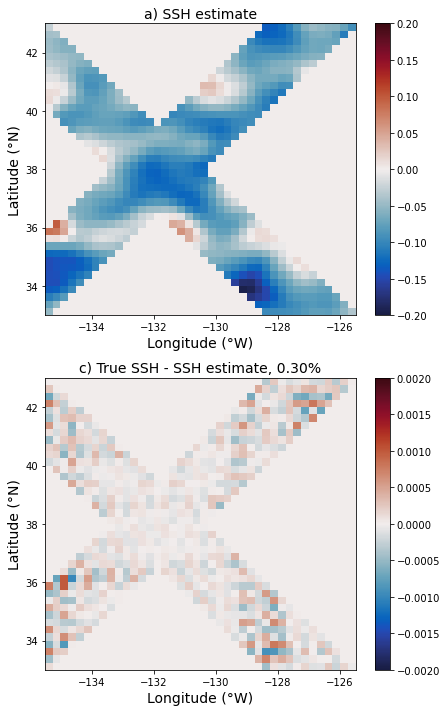

In [38]:
fig = plt.figure(figsize = (12, 10))

plt.subplot(221)
plt.pcolormesh(lon, lat, ssh_map, vmin = -.2, vmax = .2, cmap = cmo.cm.balance)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('a) SSH estimate', fontsize = 14)

plt.subplot(223)
plt.pcolormesh(lon, lat, ssh_true - ssh_map, cmap = cmo.cm.balance, vmin = -.002, vmax = .002)
plt.colorbar()
plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
plt.title('c) True SSH - SSH estimate, ' + str(ssh_diff * 100)[:4] + '%', fontsize = 14)

plt.tight_layout()
plt.savefig('aviso_ssh_estimate_'+str(date_time[day])[:10] + '_no_error.png')

#### make predictions of SSH based on the estimated amplitudes:
#### swath data, no errors

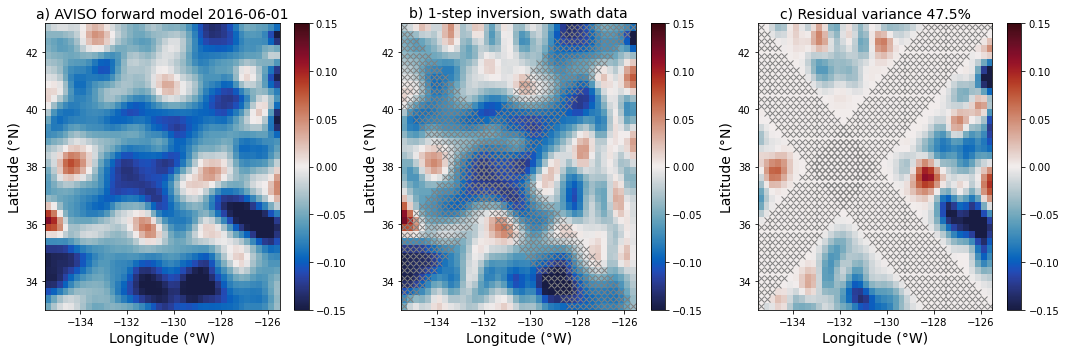

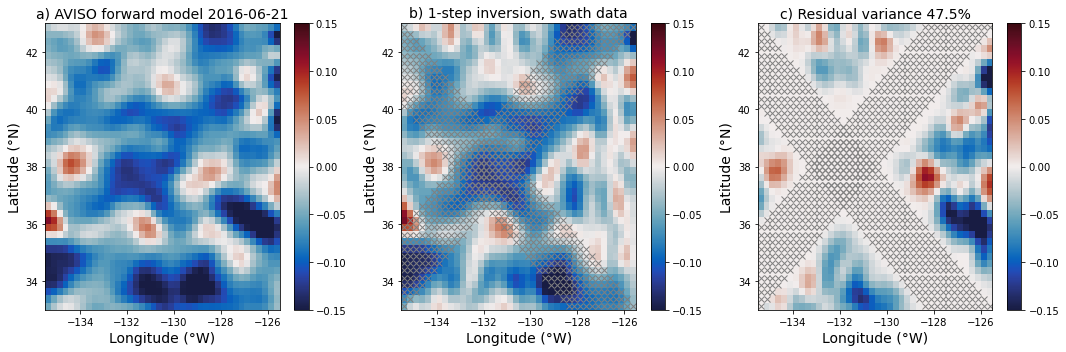

In [39]:
time_range = 8 ## 8 * 5 = 40 days
SSHA_predicted = np.zeros([time_range, MSLA0.size])
SSHA_true = np.zeros([time_range, MSLA0.size])
variance_explained_inverse = np.zeros(time_range)
MSLA_inverse = np.zeros([MSLA0.shape[0], MSLA0.shape[1], time_range])
for day in range(0, time_range, 4):
    MSLA = MSLA_fwd[:,:,day:day+1] 
    SSHA_predicted[day], SSHA_true[day], variance_explained_inverse[day] = make_ssh_predictions(day, amp_swath, MSLA, H_all) #timestamp, amp, MSLA, H_selected_iter
    MSLA_inverse[:, :, day:day+1] = reverse_vector(MSLA, SSHA_predicted[day])
    
    plt.figure(figsize = (15, 5))

    plt.subplot(131)
    plt.pcolormesh(lon, lat, MSLA[:, :, 0], cmap = cmo.cm.balance, vmin = -.15, vmax = .15) #MSLA_fwd[:, :, day]
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('a) AVISO forward model ' + str(date_time[day])[:10], fontsize = 14)

    plt.subplot(132)
    plt.plot(lon[xvalid_index], lat[yvalid_index], 'x', color = 'gray')
    plt.pcolormesh(lon, lat, MSLA_inverse[:, :, day], vmin = -.15, vmax = .15, cmap = cmo.cm.balance)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('b) 1-step inversion, swath data', fontsize = 14)
    

    residual =   MSLA[:, :, 0] - MSLA_inverse[:, :, day] #MSLA_fwd[:, :, day]
    plt.subplot(133)
    plt.plot(lon[xvalid_index], lat[yvalid_index], 'x', color = 'gray')
    plt.pcolormesh(lon, lat, residual, cmap = cmo.cm.balance, vmin = -.15, vmax = .15)
    plt.colorbar()
    plt.xlabel('Longitude (\N{DEGREE SIGN}W)', fontsize = 14)
    plt.ylabel('Latitude (\N{DEGREE SIGN}N)', fontsize = 14)
    plt.title('c) Residual variance ' + str((1 - variance_explained_inverse[day]) * 100)[:4] + '%', fontsize = 14)
    
    plt.tight_layout()
    #plt.close()
    plt.savefig('swath_' + str(date_time[day])[:10] +'_no_err_' + str(skill.size) + 'waves_with_swath.png', dpi = 100)
    
    #break